### This notebook is for analyzing the molecular gas in SDSS1531

1. Quantify Offset between YSCs and Molecular Gas
2. Lim (2008) Free Fall
3. Ram Pressure 
4. Surface Density of CO

In [1]:
#set path to beads folder
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
import sys

#astropy
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const
from astropy.wcs import WCS
from astropy.cosmology import LambdaCDM
from astropy.coordinates import Galactic

#matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm

#seaborn
import seaborn as sns

#numpy
import numpy as np

from spectral_cube import SpectralCube


#pv extractor
from pvextractor import extract_pv_slice
from pvextractor import PathFromCenter

import importlib


In [3]:
#import modules
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [4]:
#uncomment if need to reload module
importlib.reload(pf)

<module 'plotting_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/plotting_functions.py'>

In [5]:
#About
sf.sdss1531_dict

{'name': 'SDSS J1531+3414',
 'ra': 232.7936938,
 'dec': 34.2404172,
 'radius': 2.5,
 'z': 0.335,
 'cz': 100430.47}

In [6]:
z = sf.sdss1531_dict['z'] # best redshift for SDSS 1531
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.335, we have 4.7671 kpc / arcsec


In [7]:
co32_file = path_to_beads + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'
fig_path = path_to_beads + 'Figures/paper/'

In [8]:
pf.styleplots()

### 1. Quantify Offset between YSCs and Molecular Gas

In [11]:
#load hst data and ysc
hst_hdr, hst_wcs, hst_hdu = sf.load_HST_data(path_to_beads)
ysc_coords = sf.ysc_load(path_to_beads)

ysc_color, hst_cont_color = 'purple', 'k'

Cube is a Stokes cube, returning spectral cube for I component
The following kwargs were not used by contour: 'aspect'
The following kwargs were not used by contour: 'rasterized'
The following kwargs were not used by contour: 'aspect'
The following kwargs were not used by contour: 'rasterized'
The following kwargs were not used by contour: 'aspect'
The following kwargs were not used by contour: 'rasterized'


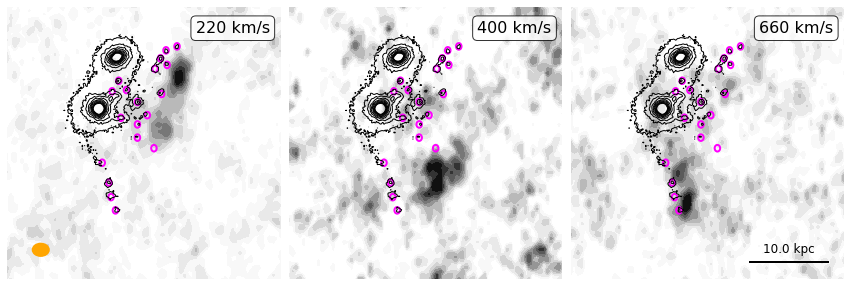

In [83]:
#data 
alma_cube = SpectralCube.read(co32_file)
hdr = alma_cube.header
velocities = [220, 400, 660]

#plot specifics
plot_width, plot_height = 5, 5
nrows, ncols = 1, 3
clims=[[0, 0.0019], [0, 0.0013], [0, 0.0013]]
zoom_moment_coords = [sf.sdss1531_dict['ra']+ 2e-4, sf.sdss1531_dict['dec']-4e-4, sf.sdss1531_dict['radius']*1.5 * u.arcsec]
ysc_color = 'magenta'

#draw
fig = plt.figure(figsize=(plot_width*ncols, plot_height*nrows))
gs1 = GridSpec(nrows, ncols)
gs1.update(wspace=0.03, hspace=0.01)

axs = []

for id_subplot in range(nrows*ncols):

    velocity = velocities[id_subplot]
    clim = clims[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(hdr), slices=('x', 'y', 0))

    ax = pf.ax_fits_map(alma_cube.hdu, cmap=cm.Greys, vmin=clim[0], vmax=clim[1],
                     coords=zoom_moment_coords, ax=ax, vel=velocity, cbar=False, 
                     contour=True)

    #HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color=hst_cont_color, lw=1)

    #YSC Overlay
    pf.overlay(ax, None, 1, None, None, clusters=True, cont_color=ysc_color, 
                ysc_coords=ysc_coords)
    ax.axis('off')

    props = dict(boxstyle='round', facecolor='w', alpha=0.8)
    ax.text(170, 170, '{} km/s'.format(velocity), color='k',
             bbox=props, fontsize=16)

    axs.append(ax)

#add beam and scale
pf.add_scale(ax, 10 * u.kpc, hdr, cosmo, color='k', ytxt=0.05, lw=2)
beam = pf.add_beam(axs[0], hdr, 115, 95, bcolor='orange', fc='orange')

# fig.savefig(fig_path + 'alma_channel_maps.pdf')

In [86]:
#draw line between beads and gas in DS9 and put points below
pointa_north, pointb_north = np.array((232.7937293,34.240680)), np.array((232.7935844,34.2405989))
pointa_south, pointb_south = np.array((232.7942073,34.2397454)),np.array((232.7941626,34.2398151))

In [89]:
north_distance = np.linalg.norm(pointa_north - pointb_north) * u.deg
south_distance = np.linalg.norm(pointa_south - pointb_south) * u.deg

In [93]:
print("Beads in North offset by: {} \n".format(north_distance.to(u.arcsec)),
        "Beads in south offset by: {}".format(south_distance.to(u.arcsec)))

Beads in North offset by: 0.5977866937510583 arcsec 
 Beads in south offset by: 0.29808739126110956 arcsec


In [102]:
north_physical_distance = north_distance * kpc_per_arcsec
south_physical_distance = south_distance * kpc_per_arcsec
print("Beads in North offset by: {} \n".format(north_physical_distance.to(u.kpc)),
        "Beads in south offset by: {}".format(south_physical_distance.to(u.kpc)))

Beads in North offset by: 2.8497109817383963 kpc 
 Beads in south offset by: 1.4210134171174502 kpc


In [105]:
gal_337_point = np.array((232.76145416696866, 34.24256527794732))
bcg_point = np.array((sf.sdss1531_dict['ra'], sf.sdss1531_dict['dec']))

distance_galaxies = np.linalg.norm(gal_337_point - bcg_point) * u.deg
physical_distance_galaxies = distance_galaxies * kpc_per_arcsec
print("Distance between BCG and z=0.3371 Galaxy is: {} \n".format(physical_distance_galaxies.to(u.kpc)))

Distance between BCG and z=0.3371 Galaxy is: 554.5095409745825 kpc 



### 2. Lim (2008): Does Freefall describe the motion of the molecular gas?

In [9]:
def rho(mass, a, r):
    #equation 1
    top = mass * a
    bottom = 2 * np.pi * np.power((r + a), 3)
    return top/bottom

def scale_length(r_half):
    #equation 2
    factor = 2 + np.sqrt(2)
    return r_half/factor

def potential(a, r, mass):
    #equation 3
    top = -1 * const.G * mass
    bottom = r + a
    return top/bottom

def v_freefalll(mass, r, a, r0=10*u.kpc, v0=0):
    #equation 4
    term1 = np.power(v0,2)/2
    term2 = potential(a, r0, mass)
    term3 = potential(a, r, mass)
    return np.sqrt(2 * (term1 + term2 - term3))

# def scale_length(r_half):
#     #equation 2
#     #factor = 2 + np.sqrt(2)
#     return r_half/1.8153#r_half/factor


Use halo mass from Sharon (2014) to estimate stellar mass using http://skyserver.sdss.org/dr16/en/tools/explore/DisplayResults.aspx?name=stellarMassPassivePortQuery&id=1237661851485929746&spec=1525703272785012736&apid=&fieldId=0x112d0ee581df0000&ra=232.794161402854&dec=34.2402901374315&plateId=1525594421133862912&mangaid= 

In [10]:
#define path using ds9 region
g = Galactic(54.6827002 * u.deg, 55.1567183 * u.deg)
total_region_path = PathFromCenter(center=g, length=10.320 * u.arcsec, angle=65.491813 * u.deg,  width=3.163 * u.arcsec)

#print pixel coordinates of path
cube = SpectralCube.read(co32_file)
m0_name, m1_name, m2_name = co32_file[:-5]+ '_M0.fits', co32_file[:-5] + '_M1.fits', co32_file[:-5] + '_M2.fits'


Cube is a Stokes cube, returning spectral cube for I component


In [11]:
total_region_slice = extract_pv_slice(cube, total_region_path)  
hdu2, hdr2 = total_region_slice, total_region_slice.header

In [12]:
# #Plot PV Diagram
# fig = plt.figure(figsize=(12, 8))

# hdu2, hdr2 = total_region_slice, total_region_slice.header
# m1hdu, m1hdr, m1wcs = pf.open_fits(m1_name)
# hdu3, hdr3 =  m1hdu, m1hdr

# cmap = cm.Reds
            
# gs1 = GridSpec(1, 2)
# gs1.update(wspace=0.05, hspace=0.01)

# radius = Angle(2.5, u.arcsec)
# mom_coords = [sf.sdss1531_dict['ra']+ 1e-4, sf.sdss1531_dict['dec']-4e-4, 
#                 15*u.arcsec]

# ax3 = fig.add_subplot(gs1[0, 0], projection=WCS(hdr3))
# ax3 = pf.ax_fits_map(hdu3, vmin=0, vmax=800, cmap=cmap, 
#                      coords=mom_coords, ax=ax3, contour=False, 
#                      nlevels=40, clip=None, lw=5, location='bottom', factor=1e3)
# pf.hide_plot_labels(ax3, hdr3)

# patches = [total_region_path.to_patches(1, wcs=cube.wcs)]
# for path in patches:
#     for p in path:
#         p.set_facecolor('grey')
#         p.set_alpha(0.4)
#         ax3.add_patch(p)

# ax2 = fig.add_subplot(gs1[0, 1], projection=WCS(hdr2))
# ax2 = pf.ax_fits_map(hdu2, cmap=cmap, ax=ax2, contour=False, vmin=0, vmax=None, cbar=False, nlevels=20)
# pf.overlay(ax2, hdu2, 1, vmin=1.4e-4, vmax=1e-3, contours=True, cont_color='k', lw=1)
# pf.add_scale(ax2, 5 * u.kpc, hdr2, cosmo, color='k', hdr_cdelt='CDELT1', ytxt=0.03, lw=2)

# ycoord = ax2.coords[1]
# ycoord.set_ticks(spacing=300 * (u.km/u.s))
# ycoord.set_format_unit(u.km / u.s)
# ycoord.set_axislabel('Velocity [km/s]')
# loc='r'
# ycoord.set_ticks_position('{}'.format(loc))
# ycoord.set_ticklabel_position('{}'.format(loc))
# ycoord.set_axislabel_position('{}'.format(loc))

# xcoord = ax2.coords[0]
# xcoord.set_ticks(number=5)
# xcoord.set_major_formatter('x')
# xcoord.set_format_unit(u.arcsec)
# xcoord.set_axislabel('Position ["]')

# ax2.set_xlim(25)




In [55]:
def freefall_velocity(height, hdr, cosmology, halo_mass=1e13*u.solMass, 
                        stellar_mass=2*np.power(10, 11.58)*u.solMass,
                        num_intervals=25, v0=600*(u.km/u.s), radius=25*u.kpc,
                        radius_0=0*u.kpc, i=20):
    """ 
    calculates velocity and distance travelend given a height
    
    """
    halo_mass = 1e13 * u.solMass #estimate within 30kpc using figure 3
    stellar_mass = np.power(10, 11.58) * u.solMass * 2 #stellar mass of one elliptical * 2

    r_effective = radius/2
    a = scale_length(r_effective) #guess half mass radius is half of the radius

    radial_distances = np.linspace(0, radius.value, num_intervals) * u.kpc
    radial_vels = v_freefalll(halo_mass, radial_distances * np.sin(i), a, r0=height, 
                                v0=v0).to(u.km/u.s)- v0

    #make all negative radial velocities 0
    idr = np.where((radial_vels > 0) & (~np.isnan(radial_vels)))
    radial_vels = radial_vels[idr] * np.cos(i)
    radial_distances = radial_distances[idr] + radius_0


    #convert velocity and distance to pixels so can plot
    wcs = WCS(hdr)
    pixel_vels = [int(wcs.wcs_world2pix(0, 0, radial_vel * 1000, 0)[2]) for radial_vel in radial_vels]
    pixel_dist = radial_distances/pf.distance(hdr['CDELT2'] * u.deg, hdr, cosmology)

    return pixel_vels, pixel_dist

In [56]:
pixel_vels_15, pixel_distances_15 = freefall_velocity(16 * u.kpc, cube.header, cosmo, radius_0=12*u.kpc)
pixel_vels_25, pixel_distances_25 = freefall_velocity(25 * u.kpc, cube.header, cosmo, radius_0=12*u.kpc)
pixel_vels_35, pixel_distances_35 = freefall_velocity(55 * u.kpc, cube.header, cosmo, radius_0=12*u.kpc)

invalid value encountered in sqrt


The following kwargs were not used by contour: 'rasterized'


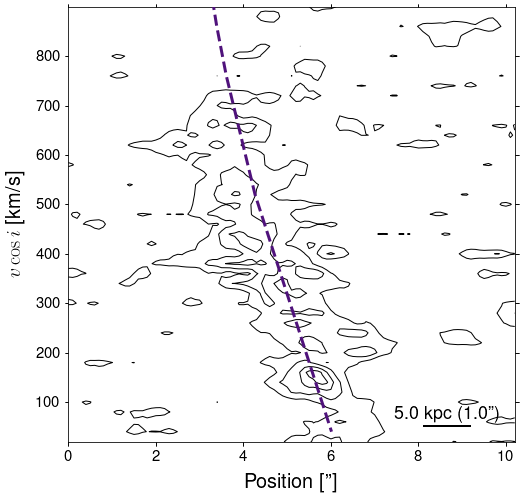

In [57]:
fig = plt.figure(figsize=(8,8))


ax2 = fig.add_subplot(111, projection=WCS(hdr2))
pf.overlay(ax2, hdu2, 1, vmin=1e-4, vmax=1e-3, contours=True, cont_color='k', lw=1)
#ax2.set_ylim(17, 40)
ycoord = ax2.coords[1]
ycoord.set_ticks(spacing=100 * (u.km/u.s))
ycoord.set_format_unit(u.km / u.s)
ycoord.set_axislabel(r'$v \cos i$ [km/s]', fontsize=20)

xcoord = ax2.coords[0]
xcoord.set_ticks(number=5)
xcoord.set_major_formatter('x')
xcoord.set_format_unit(u.arcsec)
xcoord.set_axislabel('Position ["]', fontsize=20)
ax2.set_ylim(35)

#using sharon mass
# ax2.plot(pixel_dist, pixel_vels, '-', color='g')

colors = sns.color_palette('magma_r',3)
#ax2.plot(pixel_distances_25, pixel_vels_25, '--', color=colors[0], lw=3, label='25 kpc')
#ax2.plot(pixel_distances_35, pixel_vels_35, '--', color=colors[1], lw=3, label='10 kpc')
ax2.plot(pixel_distances_15, pixel_vels_15, '--', color=colors[2], lw=3, label='17 kpc')

pf.add_scale(ax2, 5 * u.kpc, hdr2, cosmo, color='k', hdr_cdelt='CDELT1', xtf=0.9,ytf=0.015, ytxt=0.03, lw=2, fsize=18)


fig.savefig(''.join((fig_path, 'alma_freefall.pdf')))

In [56]:
pixel_distances_15

<Quantity [31.46567805, 33.65079458, 35.83591111, 38.02102765, 40.20614418,
           42.39126071, 44.57637724, 46.76149377, 48.9466103 , 51.13172683,
           53.31684337, 55.5019599 , 57.68707643, 59.87219296, 62.05730949,
           64.24242602, 66.42754255]>

### 3. Ram Prerssure 
Li e al (2018) say ram pressure could be an explanation


In [13]:
#load cube
co32_file = path_to_beads + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'
cube = SpectralCube.read(co32_file)
rms =  (0.204 *(u.mJy/u.beam)).to(u.Jy/u.beam)  

Cube is a Stokes cube, returning spectral cube for I component


In [67]:
(0.000111 * u.deg).to(u.arcsec) * kpc_per_arcsec

<Quantity 1.90493452 kpc>

In [9]:
def vterm_co(l, g, f):
    return np.sqrt((l * g)/f).to(u.km/u.s)

def vt_co(l, g, f, t):
    top = 2 * np.sqrt((l * g)/f)
    bottom = 1 + np.exp((-2 * t) * np.sqrt((f * g)/l))
    sub = np.sqrt((l * g)/f)
    return ((top/bottom) - sub).to(u.km/u.s)



Do it for each clump

In [62]:
l_cloud = (0.001479 * u.deg * kpc_per_arcsec).to(u.kpc)
r_cloud = ((0.000707/2)* u.deg * kpc_per_arcsec).to(u.kpc)
g = 3e-8 * u.cm/(u.s)**2 *1e-1

m500 = 1.8e11* u.solMass
r500 = 30 * u.kpc

picm = (m500/((4 * np.pi/3) * (r500)**3)).to(u.g/(u.cm)**3) 
v_cloud = (4/3) * np.pi * (l_cloud/2) * r_cloud**2
m_cloud = 1.9e10 * u.solMass
pcloud = m_cloud/v_cloud
f = picm/pcloud

times = np.linspace(0, 10, 300) * u.Gyr


In [63]:
vterm_co(l_cloud, g, f)

<Quantity 378.64030097 km / s>

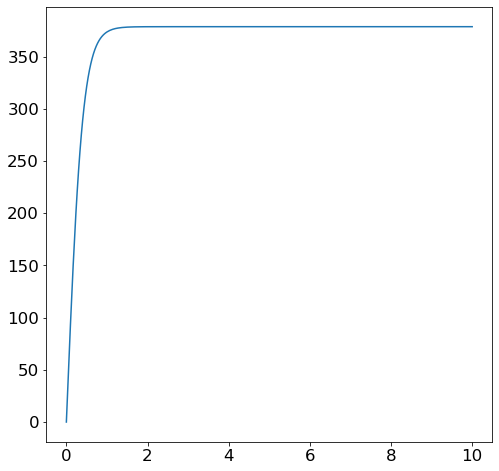

In [64]:
plt.plot(times, vt_co(l_cloud, g, f, times))

In [26]:
f.cgs

<Quantity 0.16388657>

In [27]:
0.04/2

0.02

In [ ]:
z = 0.335 # best redshift for SDSS 1531
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

### 4. Impact of ram pressure on clouds
https://www.aanda.org/articles/aa/pdf/2006/24/aa3921-05.pdf

In [9]:
G = const.G

def mass_stripped(M_gas, x):
    """
    This function calculates the stripped gas mass due to ram pressure,
    given the total gas mass and a scaling factor x.
    
    Parameters:
    - M_gas (float): gas  mass of the BCG in solar masses.
    - x (float): Scaling factor that determines the amount of stripping.
    
    Returns:
    - float: The stripped mass in solar masses.
    """
    M_strip = (x + 1) * np.exp(-x) * M_gas
    return M_strip

def mstrip_x(M_tot, M_gas, R_0, v_gal, rho_ICM):
    """
    This function calculates the scaling factor x, which determines the amount
    of stripping due to ram pressure.
    
    Parameters:
    - M_tot (float): Total mass of the BCG in solar masses.
    - R_0 (float): Petrosian radius in kpc.
    - v_gal (float): Relative velocity between the BCG and the ICM in km/s.
    - rho_ICM (float): Density of the ICM in g/cm^3.
    
    Returns:
    - float: The scaling factor x.
    """
    x = 0.5 * np.log(((G * M_tot * M_gas) / (2 * np.pi * R_0**4 * v_gal**2 * rho_ICM)).cgs)
    return x.value


In [10]:
M_star = 3.8 * 10**11 * u.solMass  # Stellar mass of the BCG
M_total = 1 * 10**13 * u.solMass # Total mass of the BCG
M_gas = 6.2e10 * u.solMass# total gas mass withi 30 kpc according to gas density profile

petrosian_rad = 30 * u.kpc #tremblay14
r_effective = petrosian_rad/2
R_0 = petrosian_rad#scale_length(r_effective) #guess half mass radius is half of the radius


v_gal = 300 * u.km/u.s  # Relative velocity between the BCG and the ICM taken to be relative velocity between galaxies; tremblay 14
rho_ICM = 8 * 10**(-26) * u.g/(u.cm)**3  # ICM density within 30 kpc

x = mstrip_x(M_total, M_gas, R_0, v_gal, rho_ICM)
M_strip = mass_stripped(M_gas, x)

print(f"The mass stripped is {M_strip/10**11} x 10^11 solar masses")
print(f"r_strip is {x*R_0}")


The mass stripped is 0.5020824841296684 solMass x 10^11 solar masses
r_strip is 23.91498274234424 kpc


In [102]:
P_ram = rho_ICM * v_gal**2 * np.pi * (3* u.kpc)**2
accel_ram = P_ram/M_gas

In [103]:
(P_ram/u.Newton).cgs

<Quantity 1.9383222e+29>

In [104]:
accel_ram.to(u.m/u.s**2)

<Quantity 1.94962037e-12 m / s2>

In [109]:
time_ram = np.sqrt((2 * 2*u.kpc)/accel_ram)

In [110]:
time_ram.to(u.Myr)

<Quantity 252.13101609 Myr>

In [ ]:
mass_sdss = 1e13 * u.solMass
m500 = 1.8e11* u.solMass
r500 = 30 * u.kpc

picm = (m500/((4 * np.pi/3) * (r500)**3)).to(u.g/(u.cm)**3)
vel = 100 * (u.km/u.s)
pram = (picm * vel**2).to(u.dyne/(u.cm**2))

In [ ]:
picm

<Quantity 1.07714559e-25 g / cm3>

In [ ]:
r0 = 15 * u.kpc
mstar =(10**11.58) * u.solMass
mgas = mass_sdss - mstar
top = const.G * mstar * mgas
bottom = vel**2 * picm * 2 * np.pi * r0**4
x = 0.5 * np.log((top/bottom).cgs)

rstrip = x * r0

In [ ]:
rstrip

<Quantity 60.31096502 kpc>

In [ ]:
mstrip = (x + 1) * np.exp(-1 * x) * mgas

In [ ]:
mstrip

<Quantity 8.66467321e+11 solMass>

In [ ]:
mstar

<Quantity 3.80189396e+11 solMass>

### 5 Could the merger have shock-heated molecualr gas in between galaxies?

In [37]:
zn = 0.335 #northern nucleus
zs = 0.3332 #southern nucleus

In [38]:
vel_diff_nuclei = const.c * (zn-zs)

In [39]:
vel_diff_nuclei.to(u.km/u.s)

<Quantity 539.6264244 km / s>

## 5. Cancelled: Estimate  density of CO
https://www.nature.com/articles/srep26896.pdf This paper uses boxes 1.5x the beam!

In [8]:
#load cube
co32_file = machine + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'
cube = SpectralCube.read(co32_file)
rms =  (0.204 *(u.mJy/u.beam)).to(u.Jy/u.beam)  

In [9]:
hdu, hdr, w = pf.open_fits(co32_file, naxis=3)

In [10]:
factor = 1.5
beam_area = (cube.beam.major * cube.beam.minor).to(u.arcsec**2)
box_area = beam_area * factor
pixel_scale = cube.header['CDELT2'] * u.deg
npixels = int(np.sqrt(box_area)/(pixel_scale.to(u.arcsec)))

In [11]:
#load moment 0
mom0_file = machine + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M0.fits'
dmom0_file = machine + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_dM0.fits'


m0hdu, m0hdr, m0wcs = pf.open_fits(mom0_file)
dm0hdu, dm0hdr, dm0wcs = pf.open_fits(dmom0_file)


(107.0, 175.0)

findfont: Font family ['Computer Modern Roman'] not found. Falling back to DejaVu Sans.


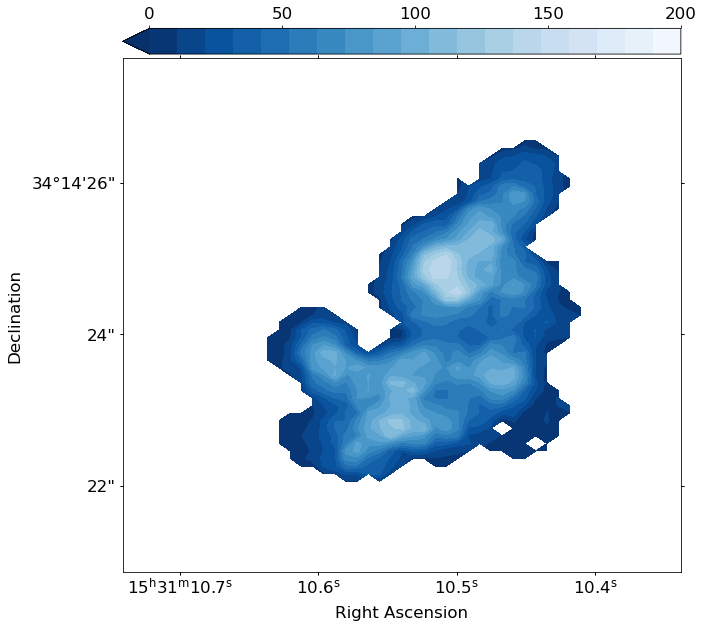

In [12]:
#Plot ALMA Mom0 to get pixel coordinate axes
mfile=mom0_file
cmap = cm.Blues_r
rms = np.sqrt(np.nanvar(dm0hdu.data))
vmin = 0
vmax=200
clip=rms
units = ' '
nlevels = 20
contour=True
mhdr = m0hdr

fig, ax = pf.plot_moments(mfile, vmin=vmin, vmax=vmax, clip=clip, units = units, cmap=cmap, contour=contour, contour_levels=nlevels)   

plt.xlim(130,180)
plt.ylim(107,175)



In [13]:
#select pixels to count. Only boxes with a median value larger than 3* the median rms of the same pixels in moment_0 are selected
npixels=5
x_pos, y_pos = [], []
xpix_range = [130, 180]
ypix_range = [107, 175]

for xpix in range(xpix_range[0], xpix_range[1], npixels):
    for ypix in range(ypix_range[0], ypix_range[1], npixels):

        flux_den = np.median(m0hdu.data[ypix:ypix+npixels, xpix:xpix+npixels])
        m0_rms = np.median(dm0hdu.data[ypix:ypix+npixels, xpix:xpix+npixels])
        
        if flux_den > (m0_rms * 3):
            x_pos.append(xpix)
            y_pos.append(ypix)
            

findfont: Font family ['Computer Modern Roman'] not found. Falling back to DejaVu Sans.


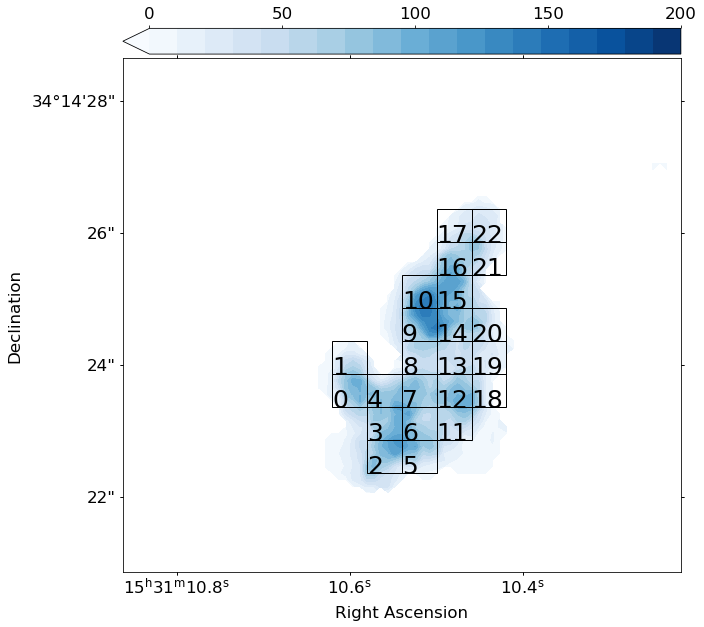

In [14]:
#ALMA Mom0
mfile=mom0_file
#rms = np.mean(dm0hdu.data)
cmap = cm.Blues
vmin = 0
vmax=200
clip=1
units = ' '
nlevels = 20
contour=True
mhdr = m0hdr

fig, ax = pf.plot_moments(mfile, vmin=vmin, vmax=vmax, clip=clip, units = units, cmap=cmap, contour=contour, contour_levels=nlevels)   

plt.xlim(115,195)
plt.ylim(107,185)

for idp in range(len(x_pos)):
    xp, yp = x_pos[idp], y_pos[idp]
    rectangle = plt.Rectangle((xp,yp), npixels, npixels, fc='none',ec="k")
    plt.text(xp, yp, idp)
    plt.gca().add_patch(rectangle)

#pf.overlay(ax, m0hdu.data, m0hdr, 1, vmin=0, vmax=0.1, contours=True, cont_color='k', nlev=1)

In [45]:
southern_id = [0,1,2,3,4,5,6,7,8,13,12,11,19, 18]
northern_id = [9, 10, 14, 15, 20, 16, 17, 21, 22]

In [15]:
#estimate integral of each pixel with spectral cube

def calc_integral(region_cube, sigma=3):

    #select emission > sigma
    cube = af.mask_cube(region_cube, clip_value=sigma)

    cubespec = cube.mean(axis=(1, 2)) 

    #find number of pixels in each velocity channel
    nspec = cube.sum(axis=(1, 2))/cubespec
    
    #convert from jy/beam to jy and get the total flux
    cubespec_Jy = af.jy(cubespec, nspec, cube) 

    #calculate the integral in jy km/s
    dv = 20 * u.km/u.s
    integral = cubespec_Jy * dv
    npix_counted = np.nansum(nspec)

    return np.nansum(integral.value ), npix_counted

In [16]:
#obtain integrals for each box

integrals = []
n_pixels_int = []

for idp in range(len(x_pos)):

    xp, yp = x_pos[idp], y_pos[idp]
    region = "physical; box({},{},{},{},0)".format(xp+2, yp+2, npixels, npixels)

    rcube = cube.subcube_from_ds9region(region)
    integral_idp, npix_idp = calc_integral(rcube)

    integrals.append(integral_idp)
    n_pixels_int.append(npix_idp.value)


In [17]:
#check that S_CO is consitent with the spectral fit (which obtained S_CO = 1.63)
sum(integrals), sum(n_pixels_int)

(1.4353533517569304, 1669.0)

##### By hand detour

In [20]:
#calculate mass in each pixel withotu spectral cube to be sure

#estimate integrals
integrals = []
for idp in range(len(x_pos)):
    xp, yp = x_pos[idp], y_pos[idp]
    fluxes = []
    for vel in range(hdr['NAXIS3']):
        fluxes.append(data[0, vel, yp: yp+ npixels, xp: xp + npixels ])

    fluxes = np.array(fluxes).flatten()
    rms = (0.204 *(u.mJy/u.beam)).to(u.Jy/u.beam).value
    #print(len(fluxes))

    flux_cut = np.where(fluxes > (3 * rms))[0]
    #print(len(flux_cut))
    #print(len(fluxes))
    npix=1
    flux_jy = af.jy(fluxes[flux_cut] * u.Jy/u.beam, npix, cube) * (u.km/u.s)

    if len(flux_cut) > 0:
        # fluxes = flux_jy[flux_cut]
        integral = np.sum(flux_jy)
    else:
        integral = 0 * u.Jy * (u.km/u.s)

    integrals.append(integral.value)


NameError: name 'data' is not defined

In [348]:
np.sum(integrals)

0.07470612

#### Back

In [21]:
rms = 0.2 * u.mJy/u.beam
integral_err = af.jy(rms, n_pixels_int, cube) * 20 * (u.km/u.s)

In [23]:
integral_err[0]

<Quantity 0.00783573 Jy km / s>

In [24]:
#estimate masses for each box and error

box_masses = []
box_masses_err = []

for idi, integral_i in enumerate(integrals):

    int_units = ((u.Jy * u.km)/u.s)
    mass = af.mol_mass(integral_i *int_units)
    mass_err = af.mol_mass(integral_err[idi])

    box_masses.append(mass.value)
    box_masses_err.append(mass_err.value)

In [25]:
np.sum(box_masses)/1e9, np.sum(box_masses_err)/1e9

(43.33724984454311, 10.124506625270914)

In [26]:
## calculate mass density
pixel_length = pf.distance(pixel_scale, hdr)
box_length = npixels * pixel_length

surface_area = box_length**2

In [27]:
mass_densities = []
mass_densities_err = []

for idm, mass in enumerate(box_masses):

    sdensity = (mass * u.solMass)/surface_area
    sdensity_err = (box_masses_err[idm] * u.solMass)/surface_area

    mass_densities.append(sdensity.to(u.solMass/(u.pc**2)).value)
    mass_densities_err.append(sdensity_err.to(u.solMass/(u.pc**2)).value)

In [28]:
max(mass_densities), max(mass_densities_err)

(665.9221352272962, 138.80737604841764)

### Does the surface density scale with the KS relation?

In [29]:
#scale sfr
#gmos reprojected to alma
registered_gfile = machine + 'Notebooks/Beads20/Overplotting/products/reprojected_newHalpha_flux_map.fits'
rghdu, rghdr, rgwcs = pf.open_fits(registered_gfile)

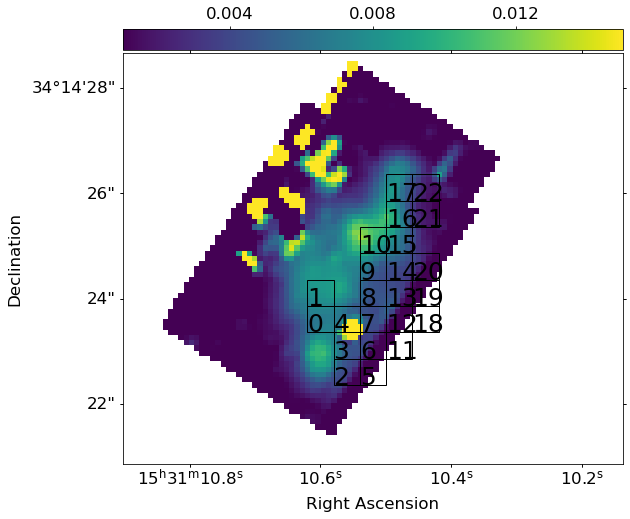

In [30]:
fig, ax = pf.plot_fits_map(rghdu.data, rghdr, vmin=0.001, vmax=0.015, cmap=cm.viridis, wcs=None) 
plt.xlim(110,205)
plt.ylim(107,185)

for idp in range(len(x_pos)):
    xp, yp = x_pos[idp], y_pos[idp]
    rectangle = plt.Rectangle((xp,yp), npixels, npixels, fc='none',ec="k")
    plt.text(xp, yp, idp)
    plt.gca().add_patch(rectangle)

In [31]:
#need to shift gmos
#save gmos file to be shifted
fits_path = machine + 'Notebooks/Beads20/Overplotting/scripts/'
#fits.writeto(fits_path + 'reprojected_newHalpha_flux_map.fits', rghdu.data, rghdr, overwrite=True)

shift gmos using python move_wcs.py reprojected_newHalpha_flux_map.fits shifted_reprojected_newHalpha_flux_map.fits 5 -3 in Terminal

In [75]:
#Load shifted fits file
sgmos_file = fits_path + 'shifted_reprojected_newHalpha_flux_map.fits'


srghdu, srghdr, srgwcs = pf.open_fits(sgmos_file)

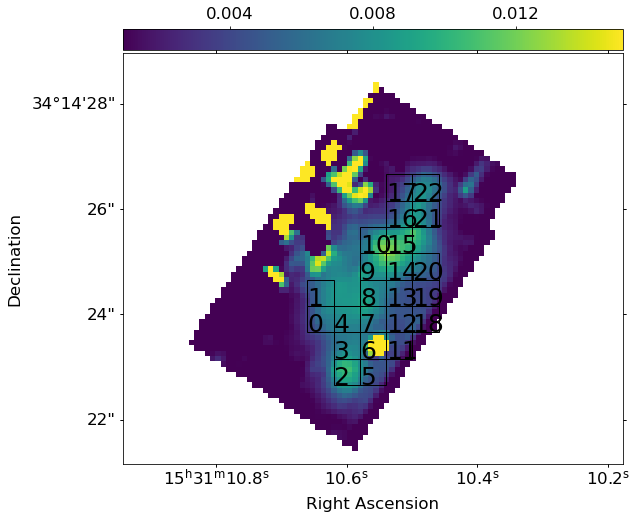

In [33]:
fig, ax = pf.plot_fits_map(srghdu.data, srghdr, vmin=0.001, vmax=0.015, cmap=cm.viridis, wcs=None) 
plt.xlim(110,205)
plt.ylim(107,185)

for idp in range(len(x_pos)):
    xp, yp = x_pos[idp], y_pos[idp]
    rectangle = plt.Rectangle((xp,yp), npixels, npixels, fc='none',ec="k")
    plt.text(xp, yp, idp)
    plt.gca().add_patch(rectangle)

In [34]:
clip_min, clip_max = 0.001, 0.013
clipped_gmos_flux = np.copy(srghdu.data)

clipped_gmos_flux[np.where(clipped_gmos_flux > clip_max)] = np.nan
clipped_gmos_flux[np.where(clipped_gmos_flux < clip_min)] = np.nan


(107.0, 185.0)

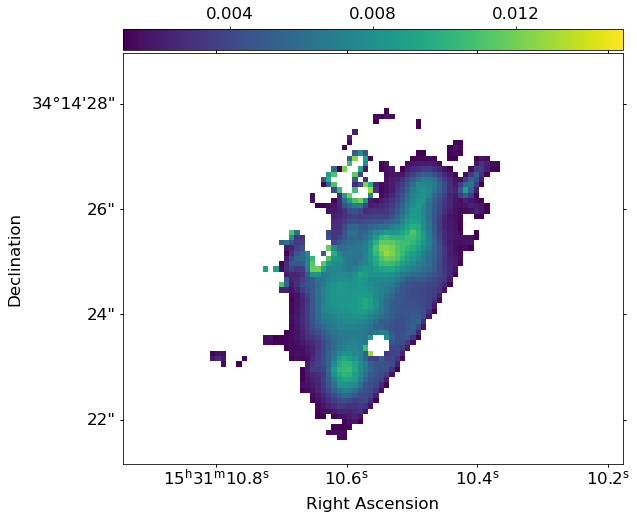

In [35]:
fig, ax = pf.plot_fits_map(clipped_gmos_flux, srghdr, vmin=0.001, vmax=0.015, cmap=cm.viridis, wcs=None) 
plt.xlim(110,205)
plt.ylim(107,185)


In [36]:
#normalize clipped data: best we can do until we have errors on properly
Ha_F = clipped_gmos_flux * 1e-16 * u.erg/ (u.s * u.cm**2)
Ha_sfr = gf.sfr_ks(gf.lum(Ha_F, zh)).cgs 

In [37]:
# #normalize sfr
# sfr_est = 10 * u.solMass/u.year
# nHa_sfr = (Ha_sfr)/np.nansum(Ha_sfr) #(Ha_sfr/norm) #* sfr_est

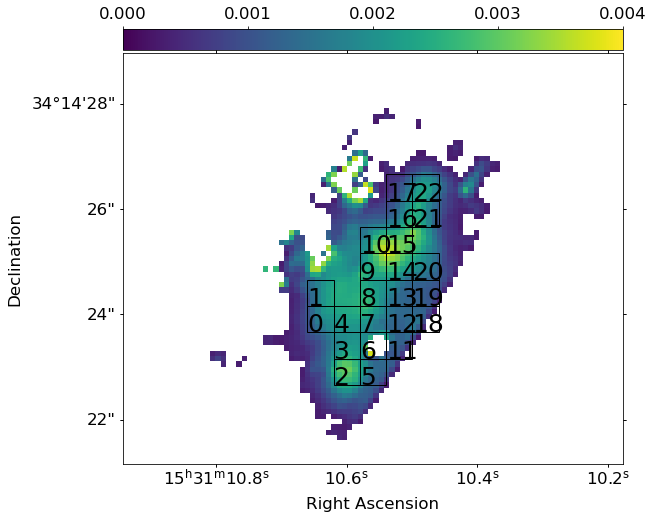

In [38]:
fig, ax = pf.plot_fits_map(Ha_sfr, srghdr, vmin=0, vmax = 0.004, cmap=cm.viridis, wcs=None) 
plt.xlim(110,205)
plt.ylim(107,185)

for idp in range(len(x_pos)):
    xp, yp = x_pos[idp], y_pos[idp]
    rectangle = plt.Rectangle((xp,yp), npixels, npixels, fc='none',ec="k")
    plt.text(xp, yp, idp)
    plt.gca().add_patch(rectangle)

In [39]:
#Let's count the sfr in the boxes
tot_sfrs= []
for idp in range(len(x_pos)):
    
    xp, yp = x_pos[idp], y_pos[idp]
    sfrs = Ha_sfr[yp + npixels, xp + npixels]

    sfrs = np.array(sfrs).flatten()

    tot_sfr = np.sum(sfrs)

    tot_sfrs.append(tot_sfr)

In [40]:
#normalize sfr
sfr_est = 10 * u.solMass/u.year
norm = np.nansum(tot_sfrs)/sfr_est.value#solMass/yr

In [41]:
tot_sfrs_norm = tot_sfrs/norm

In [42]:
tot_sfr_densities = []
for sfr in tot_sfrs_norm:
    tot_sfr_densities.append((sfr/surface_area.to(u.kpc**2)).value)

In [43]:
len(mass_densities), len(tot_sfr_densities)

(23, 23)

Text(0, 0.5, 'log $\\Sigma$SFR (M$_\\odot$/ yr kpc$^2$)')

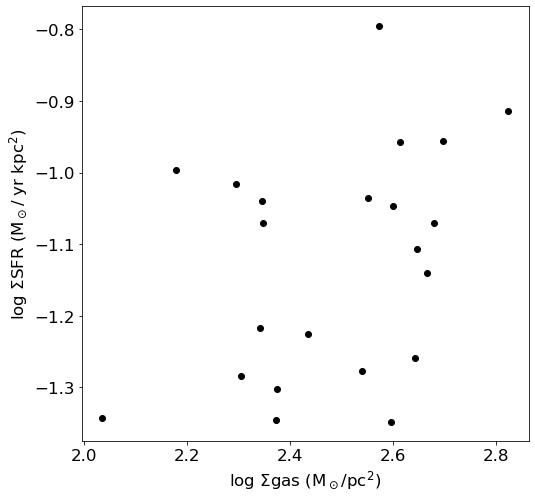

In [55]:
# for nid in northern_id:
#     plt.plot(np.log10(mass_densities[nid]),np.log10(tot_sfr_densities[nid]), 'og')
# for sid in southern_id:
#     plt.plot(np.log10(mass_densities[sid]),np.log10(tot_sfr_densities[sid]), 'or')

plt.plot(np.log10(mass_densities),np.log10(tot_sfr_densities), 'ok')
plt.xlabel(r'log $\Sigma$gas (M$_\odot$/pc$^2$)')
plt.ylabel(r'log $\Sigma$SFR (M$_\odot$/ yr kpc$^2$)')

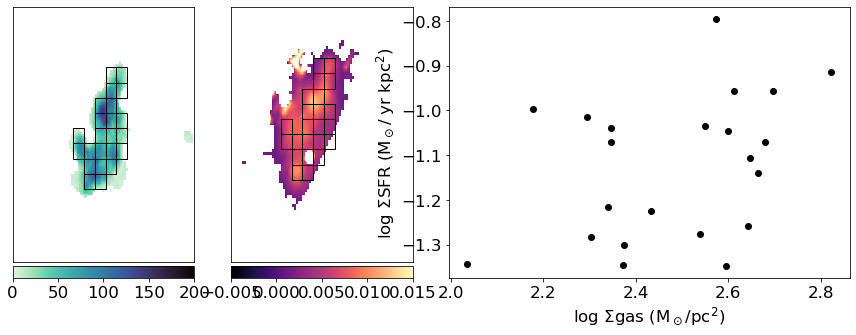

In [87]:
fig = plt.figure(figsize=(15,5))
gs1 = GridSpec(1, 4)
#gs1.update(wspace=0.5, hspace=0.01)

ax1 = fig.add_subplot(gs1[0, 0], projection=WCS(m0hdr))
mom_coords = [ra+ 1e-4, dec-4e-4, radius*1.7]
ax1 = pf.ax_fits_map(m0hdu, vmin=0, vmax=200, cmap= sns.color_palette("mako_r", as_cmap=True), 
                     coords=mom_coords, ax=ax1, contour=False, nlevels=40, clip=1, lw=5, location='bottom')
pf.hide_plot_labels(ax1, m0hdr)

for idp in range(len(x_pos)):
    xp, yp = x_pos[idp], y_pos[idp]
    rectangle = plt.Rectangle((xp,yp), npixels, npixels, fc='none',ec="k")
    ax1.add_patch(rectangle)

ax2 = fig.add_subplot(gs1[0, 1], projection=WCS(srghdr))
mom_coords = [ra+ 1e-4, dec-4e-4, radius*1.7]
ax2 = pf.ax_fits_map(srghdu, vmin=-0.005, vmax=0.015, cmap=cm.magma, 
                     coords=mom_coords, ax=ax2, contour=False, nlevels=40, clip=0.001, clip_max=0.02, lw=5, location='bottom')

for idp in range(len(x_pos)):
    xp, yp = x_pos[idp], y_pos[idp]
    rectangle = plt.Rectangle((xp,yp), npixels, npixels, fc='none',ec="k")
    ax2.add_patch(rectangle)
pf.hide_plot_labels(ax2, srghdr)

ax3 = fig.add_subplot(gs1[0, 2:])
ax3.plot(np.log10(mass_densities),np.log10(tot_sfr_densities), 'ok')
ax3.set_xlabel(r'log $\Sigma$gas (M$_\odot$/pc$^2$)')
ax3.set_ylabel(r'log $\Sigma$SFR (M$_\odot$/ yr kpc$^2$)')

fig.savefig(fig_path + 'alma_gmos_ks.pdf', dpi=100)

In [86]:
fig_path

'/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Figures/paper/'

### Old: Surface Density with Ellipsoid

In [8]:
region_string=""""
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
ellipse(232.7936646,34.2403730,1.202",1.514",330.84883)
ellipse(232.7939017,34.2397720,1.305",1.750",271.64296)
ellipse(232.7937700,34.2400595,1.702",2.613",345.09165) #total region
"""

In [247]:
def surface_density(major, minor, mass):
    alpha = np.arccos(major/minor )
    surface_area = 2 * np.pi * (major**2 + (minor**2/np.sin(alpha)) * np.log((1 + np.sin(alpha))/np.cos(alpha)))
    return (mass/surface_area).to(u.solMass/(u.pc**2))
    

In [242]:
#masses 
total_mass = 3.6e10 * u.solMass
north_mass = 2.54e10 * u.solMass
south_mass = 4.09e10 * u.solMass

In [243]:
#calculate surface area of ellipse
t_major = pf.distance(1.702 * u.arcsec, cube.header)
t_minor = pf.distance(2.613 * u.arcsec, cube.header)

n_major = pf.distance(1.202 * u.arcsec, cube.header)
n_minor = pf.distance(1.514 * u.arcsec, cube.header)

s_major = pf.distance(1.305 * u.arcsec, cube.header)
s_minor = pf.distance(1.750 * u.arcsec, cube.header)

In [244]:
n_major, n_minor, s_major, s_minor

(<Quantity 5.73005291 kpc>,
 <Quantity 7.21738777 kpc>,
 <Quantity 6.2210641 kpc>,
 <Quantity 8.34242312 kpc>)

In [248]:
#surface density
total_sd = surface_density(t_major, t_minor, total_mass)
north_sd = surface_density(n_major, n_minor, north_mass)
south_sd = surface_density(s_major, s_minor, south_mass)

In [249]:
total_sd, north_sd, south_sd

(<Quantity 21.3031314 solMass / pc2>,
 <Quantity 43.32883817 solMass / pc2>,
 <Quantity 53.05825932 solMass / pc2>)

In [257]:
sfr = 5 * u.solMass/u.yr

In [251]:
alpha = np.arccos(t_major/t_minor )
surface_area = 2 * np.pi * (t_major**2 + (t_minor**2/np.sin(alpha)) * np.log((1 + np.sin(alpha))/np.cos(alpha)))


In [258]:
sfr_kpc = sfr/surface_area

In [259]:
np.log10(sfr_kpc.value)/np.log10(total_sd.value)

-1.9036482567332038

### Calculate Mass Able to be stripped by RPS

https://www.aanda.org/articles/aa/pdf/2006/24/aa3921-05.pdf

### amount of ram pressure on clouds

In [9]:
mass_sdss = 1e13 * u.solMass
m500 = 1.8e11* u.solMass
r500 = 30 * u.kpc

picm = (m500/((4 * np.pi/3) * (r500)**3)).to(u.g/(u.cm)**3)
vel = 100 * (u.km/u.s)
pram = (picm * vel**2).to(u.dyne/(u.cm**2))

In [10]:
picm

<Quantity 1.07714559e-25 g / cm3>

In [11]:
r0 = 15 * u.kpc
mstar =(10**11.58) * u.solMass
mgas = mass_sdss - mstar
top = const.G * mstar * mgas
bottom = vel**2 * picm * 2 * np.pi * r0**4
x = 0.5 * np.log((top/bottom).cgs)

rstrip = x * r0

In [12]:
rstrip

<Quantity 60.31096502 kpc>

In [13]:
mstrip = (x + 1) * np.exp(-1 * x) * mgas

In [14]:
mstrip

<Quantity 8.66467321e+11 solMass>

In [14]:
mstar

<Quantity 3.80189396e+11 solMass>